# Выбор локации для скважины



В данном проекте нам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов.

Цель данного проекта: определить регион, с максимальной прибылью и минимальными рисками получения убытков, использую модель линейной регрессии, а прибыль и риски будем считать с использованием техники Bootstrap.

В данном проекте нужно будет изучить данные, найти признаки, которые влияют на запасы нефти в регионе. Определите чистоту данных, удалить выбросы. Обучить модель и проверить метрики точности. Используя предсказания модели посчитать прибыль и риски убытков.

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

## Загрузка и подготовка данных

In [1]:
pip install phik


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tabulate

Note: you may need to restart the kernel to use updated packages.


In [3]:
#для работы с данными 
import pandas as pd
import numpy as np
#для оценки корреляции
import matplotlib.pyplot as plt 
import phik
from phik.report import plot_correlation_matrix
from phik import report

#для обучения модели 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#метрики модели 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#для Bootstrap
from numpy.random import RandomState

#для работы функций
import tqdm
import itertools

#для выведения данных 
from IPython.display import HTML, display
from tabulate import tabulate 

In [4]:
# Create data for every region 
try:
    zero_data = pd.read_csv('/Users/zond/Downloads/geo_data_0.csv')
    first_data = pd.read_csv('/Users/zond/Downloads/geo_data_1.csv')
    second_data = pd.read_csv('/Users/zond/Downloads/geo_data_2.csv')
except:
    zero_data = pd.read_csv('/datasets/geo_data_0.csv')
    first_data = pd.read_csv('/datasets/geo_data_1.csv')
    second_data = pd.read_csv('/datasets/geo_data_2.csv')

In [5]:
def display_info(isFrame, **data):
    """
    
    Функция выводит на экран перве пять строк датафрейма, подписывая каждый
    Принимает на вход данные в следующем формате: желаемое_название_таблицы = {'доп_информация':название_датасета}
    *** Если доп информации нет, то передавайте ''
    
    """
    
    # используем функцию display,если передается фрейм и print, если передаются отсальные типы
    if isFrame:
        func = display 
    else:
        func = print
    # в цикле разберем переданные параметры 
    for data_name, data_inf in data.items():
    #обернем название в сетку, равную его длине 
        data_print = '|| ' + data_name.upper() + ' ||'
        print('='*len(data_print))
        print(data_print)
        print('='*len(data_print))
        print()
        
        #выводим фрейм
        for inf, frame in data_inf.items():
        #если доп информации нет, то выводим только фрейм 
            if not inf:
                func(frame)
        
            else:
                func(inf, frame)
            print()

    

In [6]:
display_info(True, zero_data = {'':zero_data.head()},
            first_data = {'':first_data.head()},
            second_data = {'':second_data.head()})

|| ZERO_DATA ||



,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647



|| FIRST_DATA ||



,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305



|| SECOND_DATA ||



,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [7]:
print('=================')
print('|| ZERO_DATA ||')
print('=================')
print()
print(zero_data.info())
print()
print('=================')
print('|| FIRST_DATA ||')
print('=================')
print()
print(first_data.info())
print()
print('=================')
print('|| SECOND_DATA ||')
print('=================')
print()
print(second_data.info())

|| ZERO_DATA ||

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

|| FIRST_DATA ||

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

|| SECOND_DATA ||

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 

In [8]:
display_info(False,
             Zero_Frame = {'Количество дубликатов:':zero_data['id'].duplicated().sum()},
             First_Frame = {'Количество дубликатов:':first_data['id'].duplicated().sum()},
             Second_Frame = {'Количество дубликатов:':second_data['id'].duplicated().sum()})

|| ZERO_FRAME ||

Количество дубликатов: 10

|| FIRST_FRAME ||

Количество дубликатов: 4

|| SECOND_FRAME ||

Количество дубликатов: 4



In [9]:
display_info(True,
             Zero_Frame = {'':zero_data.describe()},
             First_Frame = {'':first_data.describe()},
             Second_Frame = {'':second_data.describe()})

|| ZERO_FRAME ||



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347



|| FIRST_FRAME ||



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408



|| SECOND_FRAME ||



,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


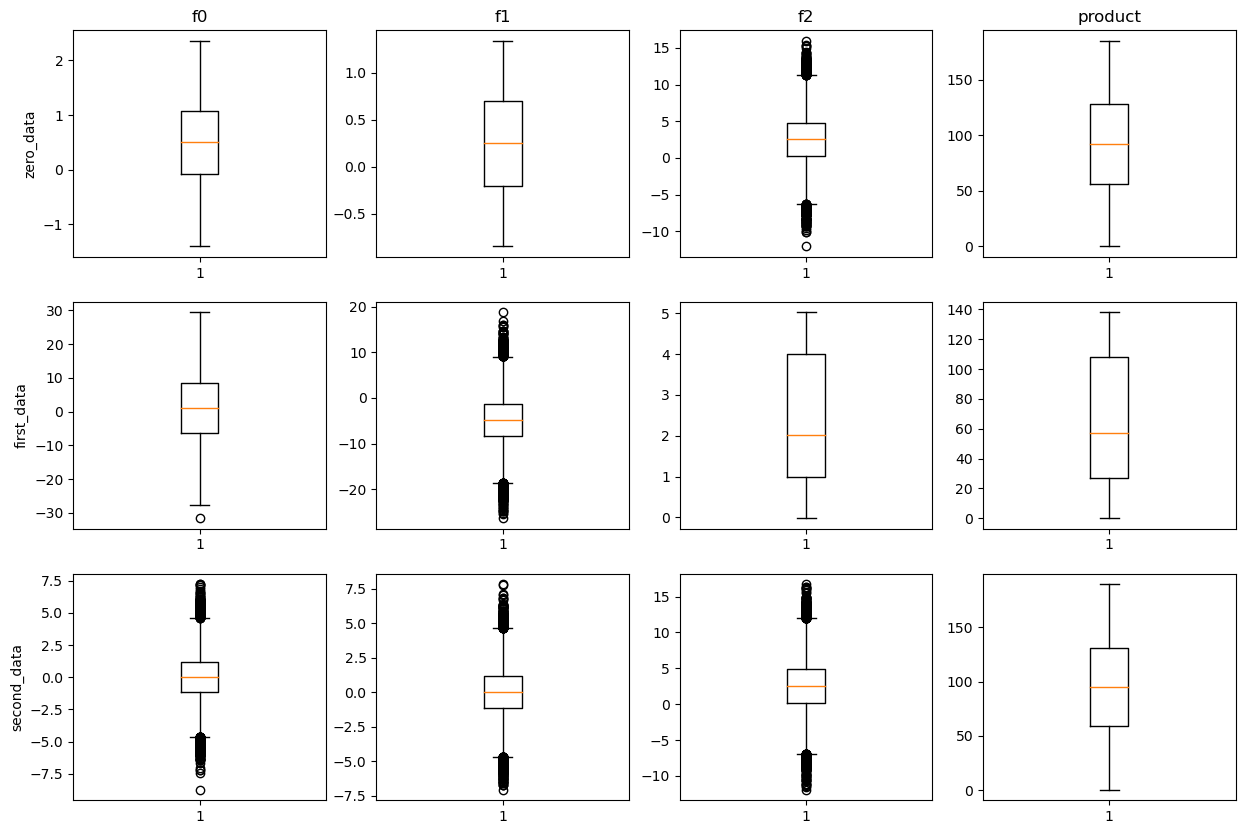

In [10]:

fig,ax = plt.subplots(3,4,figsize = (15,10))

all_frames = ["zero_data","first_data","second_data"]
num_columns = zero_data.columns[1:]
num_columns_with_columns = zip(zero_data.columns[1:],range(4))
all_frames_with_rows = zip([zero_data,first_data,second_data],range(3))
# Построим графики
for column in list(itertools.product(all_frames_with_rows,num_columns_with_columns)):
    ax[column[0][1]][column[1][1]].boxplot(column[0][0][column[1][0]])
# Добавим название фрейма изображаемого на графике
for row in range(3):
    ax[row][0].set_ylabel(all_frames[row])
# Добавим название столбца изображаемого на графике
for column in range(4):
    ax[0][column].set_title(num_columns[column])

в данных есть выбросы
выбрасы нужно будет удалить в столбцах zero_data[f2], first_data[f0], first_data[f1], second_data[f2], second_data[f1], second_data[f0]


In [11]:
#оценим зависимость в данных использую корреляцию Phik
phik = ['f0', 'f1', 'f2', 'product']
phik_zero_overview = zero_data[phik].phik_matrix()
phik_first_overview = first_data[phik].phik_matrix()
phik_second_overview = second_data[phik].phik_matrix()

interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']
interval columns not set, guessing: ['f0', 'f1', 'f2', 'product']


<function matplotlib.pyplot.show(close=None, block=None)>

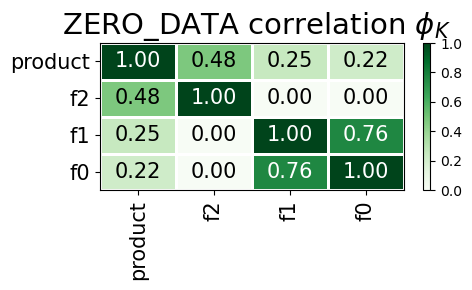

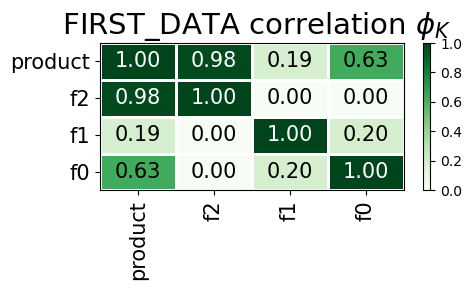

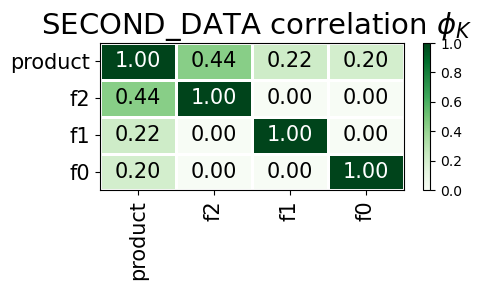

In [12]:
#построим график для каждого региона
plot_correlation_matrix(phik_zero_overview.values, 
                        x_labels=phik_zero_overview.columns, 
                        y_labels=phik_zero_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r" ZERO_DATA correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(5, 3))
plt.tight_layout()
plt.show

plot_correlation_matrix(phik_first_overview.values, 
                        x_labels=phik_first_overview.columns, 
                        y_labels=phik_first_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r" FIRST_DATA correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(5, 3))
plt.tight_layout()
plt.show

plot_correlation_matrix(phik_second_overview.values, 
                        x_labels=phik_second_overview.columns, 
                        y_labels=phik_second_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r" SECOND_DATA correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(5, 3))
plt.tight_layout()
plt.show

Мы провели первичный обзор данных представленных нам для обучения модели. После обзора можно заметить критические моменты:
- в данных присутствуют дубликаты 
- в данных есть столбец id, который нужно удалить, потому что он не явлется параметром, влияющем на количество нефти в скважине
- в данных есть выбросы выбрасы нужно будет удалить в столбцах zero_data[f2], first_data[f0], first_data[f1], second_data[f2]
- оценнивая зависимость можно сказать, что самым значимым признаком является f2, особенно в первом наборе корреляция почти равна единице. 

## Подготовка данных 

In [13]:
#удалим дубликаты, оставив только первый элемент, обновим индексы
zero_data = zero_data.drop_duplicates(subset=['id'], keep=False).reset_index(drop = True)
first_data = first_data.drop_duplicates(subset=['id'], keep=False).reset_index(drop = True)
second_data = second_data.drop_duplicates(subset=['id'], keep=False).reset_index(drop = True)


In [14]:
#удалим столбец id
zero_data = zero_data.drop('id', axis=1)
first_data = first_data.drop('id', axis=1)
second_data = second_data.drop('id', axis=1)    

In [15]:
#создадим список индексов для удаления
def remove_ouliers(frame,column):
    q25=np.array(frame[column].quantile(0.25))
    q75=np.array(frame[column].quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    del_index = []
    for index_value, value in zip(frame[column].index,frame[column]):
        if second_part <= value or value <= first_part:
            del_index.append(index_value)
    
    print('Количество строк, выбранных для удаления: ',len(del_index))
    return del_index

In [16]:
noise_data = [(zero_data,"f2"),
 (first_data,"f0"),
 (first_data,"f1"),
 (second_data,"f2")]

for frame,column in noise_data:
    indexes = remove_ouliers(frame,column)
    frame.drop(indexes,axis = 0,inplace = True)
    frame.reset_index(drop = True,inplace = True)
    

Количество строк, выбранных для удаления:  507
Количество строк, выбранных для удаления:  1
Количество строк, выбранных для удаления:  636
Количество строк, выбранных для удаления:  584


In [17]:
#функция, разделяющая на выборки 
def train_valid(data, aim):
    features = data.drop(aim, axis=1)
    target = data[aim]
    features_train, features_valid, target_train, target_valid = train_test_split(features, target,
                                                                                  test_size=0.25, random_state=12345)
    print('Признаки обучающей выборки:',features_train.shape) 
    print('Целевой признак обучающей выборки:', target_train.shape)
    print('Признаки валидационной выборки:', features_valid.shape)
    print('Целевой признак валидационной выборки:', target_valid.shape)
    return features_train, features_valid, target_train, target_valid

In [18]:
display_info(True, train_valid = {'':train_valid(zero_data, 'product')})

Признаки обучающей выборки: (74604, 3)
Целевой признак обучающей выборки: (74604,)
Признаки валидационной выборки: (24869, 3)
Целевой признак валидационной выборки: (24869,)
|| TRAIN_VALID ||



(             f0        f1        f2
 4030  -0.412885  0.761398  0.093558
 34873  0.060034  0.137302  1.377366
 39431  1.976324  0.219432  2.828037
 67805  2.155170  0.092376 -1.914054
 90935  0.178199  0.379353  5.058877
 ...         ...       ...       ...
 4094  -0.133809  0.542004  2.263462
 85412  2.032582  0.226442  3.092649
 2177  -0.647050  0.632200  7.243556
 77285  0.080439  0.257080  1.182331
 86498  1.899840 -0.143561  8.665540
 
 [74604 rows x 3 columns],
              f0        f1        f2
 19118 -0.256971  1.056090  0.957636
 7818  -0.323669  0.891629  6.591831
 65780 -1.094818  0.156596  7.803310
 48959 -0.188337  0.987211  3.531777
 78342 -0.237434  0.980451  2.055371
 ...         ...       ...       ...
 34399 -0.026198  0.321784  3.107687
 31267  0.072927  1.031559  7.856663
 83347  0.983327  0.286033  4.656728
 24891 -0.108794  0.404565 -1.987726
 2618   1.213605 -0.323582  4.013006
 
 [24869 rows x 3 columns],
 4030     138.128679
 34873     52.128403
 39431    14

удалили дубликаты, выбросы и лишний столбец. Создали функцию для разделения на выборки, провели ее тест. 

## Обучение и проверка модели

In [19]:
#создадим функцию, которая будет считать начения mse**0.5, r2 и обучать линейную регрессию

def test_mod(data, aim):
    
    features_train, features_valid, target_train, target_valid = train_valid(data, aim)
    
    #создадим, обучим, получим значения mse**0.5, r2 для модели LinearRegression
    
    lr_model = make_pipeline(StandardScaler(),LinearRegression())
    lr_model = lr_model.fit(features_train, target_train) 
    
    mod_prediction = lr_model.predict(features_valid)
    
    mse = mean_squared_error(target_valid, mod_prediction)
    r2 = r2_score(target_valid, mod_prediction)
    prod_mean = mod_prediction.mean()
    
    
    new_df = data.iloc[features_valid.index].reset_index(drop = True)
    new_df['pred'] = mod_prediction
    
    print()
    print(59*'# ')
    print(' '*(60-len('метрики для модели')),'метрики для модели'.upper())
    print(59*'# ')
    print()
    
    print('Корень из средней квадратичной ошибки для данной модели:', mse**0.5)
    
    print('Коэффициент детерминации для данной модели:', r2)
    
    print('В среднем для каждой скважины, из предсказаний модели, обём составляет:', prod_mean)
    
    return lr_model, new_df

In [20]:
lr_model_zero, zero_data_valid = test_mod(zero_data, 'product')


Признаки обучающей выборки: (74604, 3)
Целевой признак обучающей выборки: (74604,)
Признаки валидационной выборки: (24869, 3)
Целевой признак валидационной выборки: (24869,)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
                                           МЕТРИКИ ДЛЯ МОДЕЛИ
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Корень из средней квадратичной ошибки для данной модели: 37.723754923964115
Коэффициент детерминации для данной модели: 0.2745428314315571
В среднем для каждой скважины, из предсказаний модели, обём составляет: 92.59323413054406


In [21]:
lr_model_first, first_data_valid = test_mod(first_data, 'product')


Признаки обучающей выборки: (74516, 3)
Целевой признак обучающей выборки: (74516,)
Признаки валидационной выборки: (24839, 3)
Целевой признак валидационной выборки: (24839,)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
                                           МЕТРИКИ ДЛЯ МОДЕЛИ
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Корень из средней квадратичной ошибки для данной модели: 0.8892698446231949
Коэффициент детерминации для данной модели: 0.9996259917954178
В среднем для каждой скважины, из предсказаний модели, обём составляет: 68.6386802421195


In [22]:
lr_model_second, second_data_valid = test_mod(second_data, 'product')

Признаки обучающей выборки: (74556, 3)
Целевой признак обучающей выборки: (74556,)
Признаки валидационной выборки: (24852, 3)
Целевой признак валидационной выборки: (24852,)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
                                           МЕТРИКИ ДЛЯ МОДЕЛИ
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

Корень из средней квадратичной ошибки для данной модели: 40.17879422114336
Коэффициент детерминации для данной модели: 0.19103051419177086
В среднем для каждой скважины, из предсказаний модели, обём составляет: 95.2178456606533


In [23]:
display_info(True,
             Zero_Frame = {'':zero_data_valid.head()},
             First_Frame = {'':first_data_valid.head()},
             Second_Frame = {'':second_data_valid.head()})

|| ZERO_FRAME ||



,f0,f1,f2,product,pred
0,-0.256971,1.056090,0.957636,141.382937,68.230916
1,-0.323669,0.891629,6.591831,130.350731,108.015026
2,-1.094818,0.156596,7.803310,155.020513,123.630291
3,-0.188337,0.987211,3.531777,84.376057,86.680871
4,-0.237434,0.980451,2.055371,53.781415,76.712712



|| FIRST_FRAME ||



,f0,f1,f2,product,pred
0,-12.650773,-5.227895,0.993941,30.132364,30.396429
1,-2.577407,-11.120784,3.004238,84.038886,83.239533
2,-6.096421,-9.147040,3.004817,84.038886,83.722156
3,-11.798152,-6.792239,0.001267,3.179103,3.555845
4,6.002188,-5.654493,-0.002992,0.000000,0.835215



|| SECOND_FRAME ||



,f0,f1,f2,product,pred
0,-0.662662,1.493072,6.262971,49.376599,117.121549
1,-0.760836,0.758838,3.163536,109.630807,99.007337
2,1.019207,-1.802514,0.877059,53.080856,85.417322
3,-2.494724,-2.988781,8.163940,106.412185,128.397080
4,-2.057819,-2.228968,1.792222,130.451928,91.108312


Моедли обучились и точность их предсказаний страдает, что показывает коэффициент детерминации. Данный коэффициент должен стремится к единице, а вот значение в 0.27 - это очень плохо. Так же модель ошибается в среднем на 37 тыс. баррелей, что составляет почти половину от прогноза. Все Предсказания мы сохранили в новый датафрейм, этот датафрейм состоит только из валидационной выборки

## Подготовка к расчёту прибыли

In [24]:
BUDGET = 10**10
PPB = 450000
POINTS = 500
FIN_POINTS = 200
TRESHOLD = 0.025
non_damage_point = (BUDGET/PPB/FIN_POINTS)
print("Достаточный объем добычи с одной скважины для безубыточной разработки",round(non_damage_point,2))

Достаточный объем добычи с одной скважины для безубыточной разработки 111.11


In [25]:
display_info(True,
             Zero_Frame = {'':zero_data_valid.describe()},
             First_Frame = {'':first_data_valid.describe()},
             Second_Frame = {'':second_data_valid.describe()})

|| ZERO_FRAME ||



,f0,f1,f2,product,pred
count,24869.000000,24869.000000,24869.000000,24869.000000,24869.000000
mean,0.499245,0.250260,2.495486,91.977742,92.593234
std,0.869735,0.504675,3.193817,44.291232,23.220214
min,-1.275033,-0.817951,-6.349353,0.000000,20.383896
25%,-0.073593,-0.201654,0.277132,55.941578,76.533244
50%,0.503825,0.249299,2.499921,90.406268,92.674816
75%,1.066065,0.699426,4.703096,127.954642,108.721576
max,2.266803,1.343769,11.348775,185.364347,165.764081



|| FIRST_FRAME ||



,f0,f1,f2,product,pred
count,24839.000000,24839.000000,24839.000000,24839.000000,24839.000000
mean,1.173186,-4.837228,2.487718,68.634225,68.638680
std,8.970845,4.990973,1.704049,45.983470,45.955712
min,-24.950386,-18.626037,-0.017686,0.000000,-2.057086
25%,-6.313843,-8.295295,1.000058,26.953261,28.508284
50%,1.239410,-4.907532,2.009208,57.085625,57.690238
75%,8.634621,-1.406420,3.999930,107.813044,109.310126
max,28.400992,9.050688,5.016804,137.945408,139.978243



|| SECOND_FRAME ||



,f0,f1,f2,product,pred
count,24852.000000,24852.000000,24852.000000,24852.000000,24852.000000
mean,0.009889,-0.003718,2.531312,95.230974,95.217846
std,1.738661,1.729908,3.400262,44.672429,19.877477
min,-7.450587,-7.084020,-6.944602,0.028097,39.578832
25%,-1.167196,-1.170884,0.164506,59.662084,81.398780
50%,0.017772,-0.003243,2.508283,95.186625,95.097082
75%,1.165098,1.163400,4.886646,131.022577,108.971671
max,7.238262,7.101618,11.945919,190.011722,150.354264


Сравнивая средние запасы в каждом регионе можно сказать, что они все ниже точки безубыточности, но 3q  больше, поэтому эти регионы можно использовать для разработки 

## Расчёт прибыли и рисков 

In [26]:
def top_200(prediction, target, ppb):

    top_points = prediction.sort_values(ascending=False).head(200).index
    production = target.iloc[top_points].sum()
    income = production * PPD
    
    return income

In [27]:
state = RandomState(12345) 

In [28]:

def income(true_target, pred_target):
    sort_Series = pd.Series(pred_target).sort_values(ascending=False)[:200]
    true_target_sort = (true_target
                         .reset_index(drop = True)[sort_Series.index])
    sum_true = true_target_sort.sum()
    inc = ((sum_true * PPB)-BUDGET)/10**6
    
    return round(inc,2)

In [29]:
display_info(False, Zero_region = {'Прибыль по 200 скважинам млн:':income(zero_data_valid['product'], zero_data_valid['pred'])},
             First_region = {'Прибыль по 200 скважинам млн:':income(first_data_valid['product'], first_data_valid['pred'])},
             Second_region = {'Прибыль по 200 скважинам млн:':income(second_data_valid['product'], second_data_valid['pred'])})
    

|| ZERO_REGION ||

Прибыль по 200 скважинам млн: 3267.96

|| FIRST_REGION ||

Прибыль по 200 скважинам млн: 2415.09

|| SECOND_REGION ||

Прибыль по 200 скважинам млн: 2457.21



In [30]:
def confidence_interval(true_target,pred_target):
    samples = []
    for i in tqdm.tqdm(range(1000)):
        sample = pd.Series(pred_target).sample(n = 500, replace=True, random_state=state)
        samples.append(income(true_target,sample))
    samples = pd.Series(samples)
    print(samples.mean())
    print(samples.apply(lambda x: x < 0).sum()/len(samples)*100,"%")
    
    lower = samples.quantile(0.025)
    upper = samples.quantile(0.975)
    return round(lower,2), round(upper,2)

In [31]:
print('Прибыль в млн рублей:')
print("95% доверительный итервал для Нулевового региона лежит между:",
      confidence_interval( zero_data_valid['product'], zero_data_valid['pred']))
print()
print('Прибыль в млн рублей:')
print("95% Доверительный итервал для Второго региона лежит между:",
      confidence_interval(first_data_valid['product'], first_data_valid['pred']))
print()
print('Прибыль в млн рублей:')
print("95% Доверительный итервал для Первого  региона лежит между:",
      confidence_interval(second_data_valid['product'], second_data_valid['pred']))

Прибыль в млн рублей:


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2431.58it/s]


378.29803000000027
7.1 %
95% доверительный итервал для Нулевового региона лежит между: (-106.77, 852.19)

Прибыль в млн рублей:


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2724.55it/s]


437.9227299999999
1.4000000000000001 %
95% Доверительный итервал для Второго региона лежит между: (53.79, 849.43)

Прибыль в млн рублей:


100%|█████████████████████████████████████| 1000/1000 [00:00<00:00, 2725.23it/s]

361.79733000000016
9.5 %
95% Доверительный итервал для Первого  региона лежит между: (-200.31, 869.46)


В данном раздели создали две функции для подсчета прибыли и доверительного интервала. После чего использовали их для трех регионов. 
Единственный регион, который нам подходит - это первый регион. Потому что риски тут ниже нашего порога.

<div class="alert alert-block alert-info">
<b> <h1>ВЫВОД </h1> </b> <p>В ходе проекта мы достигли цель, поставленную в начале. Регион, который можно рекомендовать - это первый регион. Потому что только он проходит порог риска, который поставил заказчик. </ p>  
<p>В данном проекте были проделаны следующие шаги:
    <li>были импортированы данные по трем регионам</li>
    <li>проведен первичный анализ, который выявил ряд проблем</li>
    <li>была проведена оценка корреляции(данная оценка показала, что в данных из первого региона имеется высокая зависимость между признаками и целевым показателем. Что в будущем может привести к более точному обучению модели на этих данных.)</li>
    <li>были удалены дубликаты данных</li>
    <li>были удалены выбросы</li>
    <li>обучили каждую модель на тренировочном наборе данных</li>
    <li>сделали предсказания на валидационном наборе данных</li>
    <li>предсказания добавили к каждой таблице, позже будем использовать их для подсчёта прибыли</li>
    <li>нашли точку безубыточности </li>
    <li>расчитали прибыль, риск и доверительный интервал с использованием Bootstrap</li>

 
</div>